In [2]:
import pandas as pd
from jupyterthemes import jtplot
import numpy as np
import pylab as plt

jtplot.style()

In [64]:
df=pd.read_csv('../qmodels/relaxation_1980.csv',index_col=0).T.rename(columns={0:'R',1:'L',2:'RL'})

In [65]:
df

,R,L,RL
1,0.127275,0.126215,0.107205
101,0.232988,0.266529,0.272860
201,0.183198,0.190130,0.217241
301,0.204412,0.182240,0.148096
401,0.168168,0.156121,0.151304
...,...,...,...
9501,0.143673,0.149554,0.071148
9601,0.142714,0.139478,0.071024
9701,0.145885,0.150131,0.072501
9801,0.146442,0.145068,0.073057


In [66]:
import math

def triangle_area(a, b, c):
    """Calculate the area of a triangle given its side lengths using Heron's formula."""
    s = (a + b + c) / 2
    a=(s * (s - a) * (s - b) * (s - c))
    if a > 0:
         return math.sqrt(s * (s - a) * (s - b) * (s - c))
    else:
         return 0.

def calculate_changes(triangle1, triangle2):
    """Calculate changes in area and side lengths between two triangles."""
    area1 = triangle_area(*triangle1)
    area2 = triangle_area(*triangle2)

    area_change = area2 - area1
    #side_length_changes = [triangle2[i] - triangle1[i] for i in range(3)]

    return area_change

In [67]:
Z=df.head(1).values[0]
def getChange(row,R0=Z[0],L0=Z[1],RL0=Z[2]):
    return calculate_changes((R0,L0,RL0),(row.R,row.L,row.RL))
def getChangeS(row,R0=Z[0],L0=Z[1],RL0=Z[2]):
    return .1*np.array(calculate_changes((R0,L0,RL0),(row.R,row.L,row.RL))[1]).mean()


In [68]:
df['dA']=df.apply(getChange,axis=1)
#df['ds']=df.apply(getChangeS,axis=1)
df

,R,L,RL,dA
1,0.127275,0.126215,0.107205,0.000000
101,0.232988,0.266529,0.272860,0.033578
201,0.183198,0.190130,0.217241,0.015391
301,0.204412,0.182240,0.148096,0.015588
401,0.168168,0.156121,0.151304,0.008635
...,...,...,...,...
9501,0.143673,0.149554,0.071148,-0.000381
9601,0.142714,0.139478,0.071024,-0.000290
9701,0.145885,0.150131,0.072501,0.000032
9801,0.146442,0.145068,0.073057,0.000274


<AxesSubplot:>

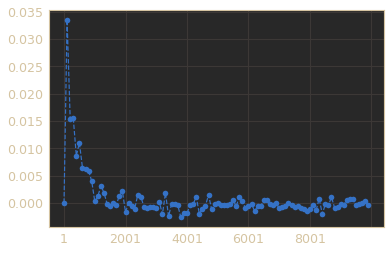

In [69]:
df.dA.plot(style='--o')
#df.ds.plot(style='--o')


In [89]:
# Exponential decay function
def exponential_decay(t, A, lambda_, B):
    return A * np.exp(-lambda_ * t) + B
# Exponential decay function
def polyspike(t, a,b,c):
    return a*t**2 + b*t + c
N=2

Model={}
Model['spikemodel']=polyspike
Model['decaymodel']=exponential_decay
Model['split']=N
Model['param_spike']=(0,0,0)
Model['param_decay']=(0,0,0)
Model['time'] = df.index.values.astype(float)*(1/1000)

def genresponse(Model):
    ys=Model['spikemodel'](Model['time'][:Model['split']], Model['param_spike'][0],Model['param_spike'][1],Model['param_spike'][2] )
    yd=Model['decaymodel'](Model['time'][Model['split']:], Model['param_decay'][0],Model['param_decay'][1], Model['param_decay'][2])
    return np.array(list(ys)+list(yd))

Model['genresponse'] = genresponse
Model['response'] = None

In [105]:
df_= df[N:]
time=np.array(df_.index.values).astype(float)/10000
variable = df_.dA.ewm(alpha=.05).mean().values
from scipy.optimize import curve_fit
paramsE, covarianceE = curve_fit(exponential_decay, time, variable,maxfev = 80000)

timeA=time.copy()
yA=exponential_decay(time, *paramsE).copy()
Model['param_decay']=(paramsE[0],paramsE[1],paramsE[2])
yE=exponential_decay(time, *paramsE)

In [110]:
pd.DataFrame(df_.dA).to_csv('xx.csv')
#plt.plot(yA)

In [112]:
response_data = df_['dA'].values
time = np.arange(len(response_data))

def decay_function(t, A, tau, C):
    return A * np.exp(-t / tau) + C

params, covariance = curve_fit(decay_function, time, response_data)
time_constant_tau = params[1]
time_constant_tau

4.850257943693128

In [91]:
df_= df[:N]
time=np.array(df_.index.values).astype(float)/10000
variable = df_.dA.values
from scipy.optimize import curve_fit
paramsi, covariancei = curve_fit(polyspike, time, variable,maxfev = 20000)
a,b,c=paramsi
timeB=time.copy()
yB=polyspike(time, a,b,c).copy()
Model['param_spike']=(paramsi[0],paramsi[1],paramsi[2])

TypeError: The number of func parameters=3 must not exceed the number of data points=2

In [92]:
Model['response']=np.array(list(yB)+list(yE))

ValueError: x and y must have same first dimension, but have shapes (100,) and (102,)

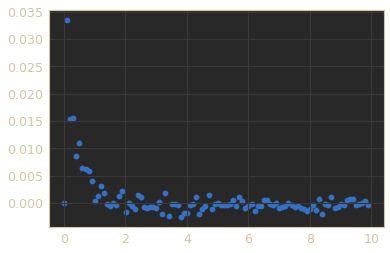

In [93]:
time=np.array(df.index.values).astype(float)
plt.scatter(time/1000, df.dA.values, label='Data')
#plt.plot(time[:4]*10000, polyspike(time[:4], *paramsi), label='Fit', color='red')
plt.plot(Model['time'], Model['response'], label='Fit', color='red')
#plt.xscale('symlog')
plt.xlabel('Time')
plt.ylabel('Variable')
plt.legend()

In [15]:
Model['time_const']=Model['param_decay'][1]
Model['half_life'] = np.log(2) / Model['time_const']
Model['amplitude'] = Model['param_spike'][1]
Model

{'spikemodel': <function __main__.polyspike(t, a, b, c)>,
 'decaymodel': <function __main__.exponential_decay(t, A, lambda_, B)>,
 'split': 4,
 'param_spike': (-73.65737486801915,
  2.5031522918575435,
  0.0010325545016767604),
 'param_decay': (0.11989040010618986, 70.43675719173226, 0.007513761613073105),
 'time': array([1.000e-03, 1.010e-01, 2.010e-01, 3.010e-01, 4.010e-01, 5.010e-01,
        6.010e-01, 7.010e-01, 8.010e-01, 9.010e-01, 1.001e+00, 1.101e+00,
        1.201e+00, 1.301e+00, 1.401e+00, 1.501e+00, 1.601e+00, 1.701e+00,
        1.801e+00, 1.901e+00, 2.001e+00, 2.101e+00, 2.201e+00, 2.301e+00,
        2.401e+00, 2.501e+00, 2.601e+00, 2.701e+00, 2.801e+00, 2.901e+00,
        3.001e+00, 3.101e+00, 3.201e+00, 3.301e+00, 3.401e+00, 3.501e+00,
        3.601e+00, 3.701e+00, 3.801e+00, 3.901e+00, 4.001e+00, 4.101e+00,
        4.201e+00, 4.301e+00, 4.401e+00, 4.501e+00, 4.601e+00, 4.701e+00,
        4.801e+00, 4.901e+00, 5.001e+00, 5.101e+00, 5.201e+00, 5.301e+00,
        5.401e+00,

In [1]:
A=[1.5,1.3,.8]
B=[275, 50, 25]

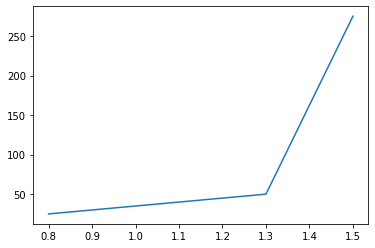

In [3]:
import pylab as plt
plt.plot(A,B)